In [122]:
import pandas
import keras
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import pathlib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

In [123]:
# CLASSIFIER PARAMETERS
class_col = 'blueWins'

# TRAINING PARAMETERS
n_layers = 1
n_neurons = 8
hidden_neuron_activation = 'tanh' # 'tanh', 'relu', 'sigmoid'
my_metric = 'Accuracy' # 'Precision', 'Recall', 'Accuracy'
min_improvement = 0.01
my_patience = 500
base_max_epoch = 10*my_patience
optimizer_name = 'adam' # 'sgd', 'adam', 'rmsprop'
lr = 0.001
n_k_folds = 5
hyperconfig_stat = 'mean' # 'mean', 'median', 'max', 'min'
loss_function = "mse"
activation_type = 'sigmoid' # 'linear', 'logistic', 'softmax'


# CONTROL RANDOMNESS
random_seed = 33

In [124]:
# SET THE RANDOM SEED
keras.utils.set_random_seed(random_seed)

In [125]:
# BUILD PATH TO DATA USING PATHLIB
this_folder = pathlib.Path.cwd()
data_folder = this_folder.parent
path_to_rankedLOL = data_folder / 'datasets' / 'high_diamond_ranked_10min.csv'
games = pandas.read_csv(path_to_rankedLOL)

In [126]:
best_features = pandas.DataFrame()
best_features["blueWins"] = games["blueWins"]
best_features["gold_diff"] = games["blueGoldDiff"]
best_features["exp_diff"] = games["blueExperienceDiff"]
best_features["kills_diff"] = games["blueKills"] - games["redKills"]
best_features["dragons_diff"] = games["blueDragons"] - games["redDragons"]
best_features["deaths_diff"] = games["blueDeaths"] - games["redDeaths"]

best_features

,blueWins,gold_diff,exp_diff,kills_diff,dragons_diff,deaths_diff
0,0,643,-8,3,0,-3
1,0,-2908,-1173,0,-1,0
2,0,-1172,-1033,-4,1,4
3,0,-1321,-7,-1,0,1
4,0,-1004,230,0,-1,0
...,...,...,...,...,...,...
9874,1,2519,2469,3,1,-3
9875,1,782,888,2,1,-2
9876,0,-2416,-1877,-1,-1,1
9877,0,-839,-1085,-1,1,1


In [127]:
# PREPARE VARS AND ENCODER
my_vars = list(games.columns[games.columns != class_col])
df_X = games[my_vars]
one_hot = OneHotEncoder(sparse_output=False)
df_Y_categorical = games[[class_col]]
Y_array_categorical = df_Y_categorical.to_numpy()
one_hot.fit(Y_array_categorical)
df_Y = pandas.DataFrame(one_hot.transform(Y_array_categorical))
df_Y.columns = one_hot.categories_
n_classes = df_Y.columns.shape[0]

# PREPARE DATA
X = df_X.to_numpy()
Y = df_Y.to_numpy()

# NORMALIZE VARIABLES
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

#ENCODER
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y, test_size=0.2, random_state=random_seed)
# Dimensão da camada de codificação
encoding_dim = 8
# Definir a camada de entrada
input_encoder = keras.Input(shape=(len(my_vars), ))
# Definir a camada de codificação
encoded = keras.layers.Dense(encoding_dim, activation=hidden_neuron_activation)(input_encoder)
# Definir a camada de decodificação
decoded = keras.layers.Dense(len(my_vars), activation=activation_type)(encoded)
# Criar o modelo autoencoder
autoencoder = keras.models.Model(input_encoder, decoded)
# Criar o modelo encoder
encoder = keras.models.Model(input_encoder, encoded)
# Compilar o modelo autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# Treinar o modelo autoencoder
autoencoder.fit(X_train, X_train,
epochs=my_patience,
batch_size=len(my_vars),
shuffle=True,
verbose=0,
validation_data=(X_val, X_val))

# Codificar os dados de treino e teste
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


In [128]:
X_train_encoded.shape[1]

8

In [129]:

# BASE TRAINING LOOP

# DECLARE NET
inputs = keras.Input(shape=(X_train_encoded.shape[1], ))
hidden = keras.layers.Dense(n_neurons, activation=hidden_neuron_activation)(inputs)
hidden = keras.layers.Dense(n_neurons, activation=hidden_neuron_activation)(hidden)
bnorm = keras.layers.BatchNormalization()(hidden)
outputs = keras.layers.Dense(n_classes, activation=activation_type)(bnorm)

my_net = keras.Model(inputs=inputs, outputs=outputs)
val_metric_name = 'val_{}'.format(my_metric)

match optimizer_name:
    case 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=lr)
    case 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    case 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    case _:
        raise ValueError(f'Optimizer {optimizer_name} not recognized')

my_net.compile(optimizer=optimizer, loss=loss_function, metrics=[my_metric])
es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
es_metric = keras.callbacks.EarlyStopping(monitor=my_metric, mode='max', patience=my_patience, min_delta=min_improvement, restore_best_weights=True)

# FIT
history = my_net.fit(X_train_encoded, Y_train, validation_data=(X_val_encoded, Y_val), batch_size=X_train_encoded.shape[0], epochs=base_max_epoch, verbose=0, callbacks=[es_loss, es_metric])

# UNPACK TRAINING RESULTS
model_loss = history.history['loss'][-1]
model_val_loss = history.history['val_loss'][-1]
metric_val = history.history[my_metric][-1]
val_metric_val = history.history[val_metric_name][-1]
n_epochs = len(history.history['val_loss'])
result_dict = {'optimizer_name' : optimizer_name,
                'loss': model_loss,
                'val_loss': model_val_loss,
                my_metric: metric_val,
                val_metric_name: val_metric_val,
                'epochs': n_epochs,
                'net': my_net,
                'history': history}

result_dict


{'optimizer_name': 'adam',
 'loss': 0.1760919988155365,
 'val_loss': 0.18892811238765717,
 'Accuracy': 0.7368088364601135,
 'val_Accuracy': 0.715080976486206,
 'epochs': 816,
 'net': <Functional name=functional_32, built=True>,
 'history': <keras.src.callbacks.history.History at 0x19a9733d430>}

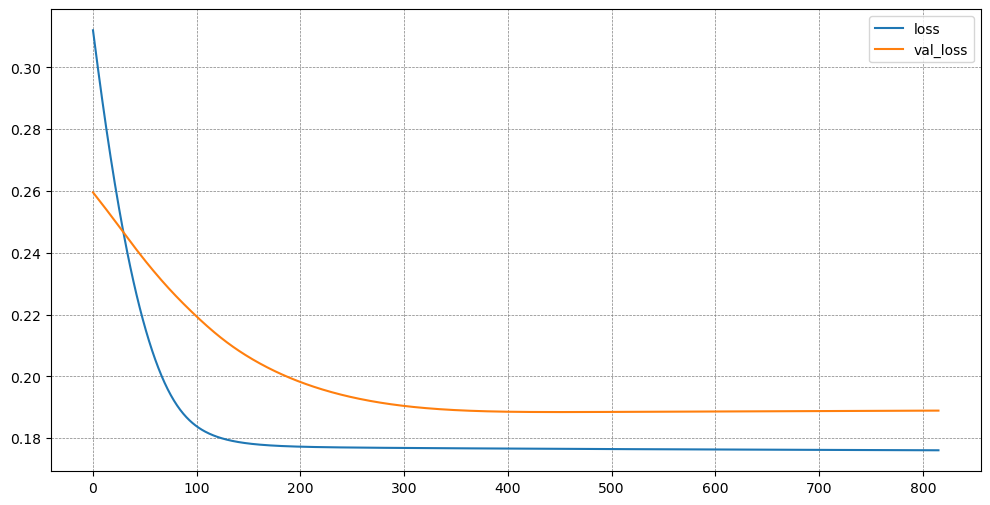

In [130]:
# PLOT TRAINING HISTORY
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = ax.plot(history.history['loss'], label='loss')
_ = ax.plot(history.history['val_loss'], label='val_loss')
_ = ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')
_ = ax.legend()